In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.optimize import linprog
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False


In [2]:
def max_step(x, dx, tau=0.99):
    idx = dx < 0
    if not np.any(idx):
        return 1.0
    return min(1.0, tau * np.min(-x[idx] / dx[idx]))

def kkt_residuals(A, b, c, x, y, s, mu):
    r_b = A @ x - b
    r_c = A.T @ y + s - c
    r_mu = x * s - mu
    return r_b, r_c, r_mu

def solve_newton_step(A, b, c, x, y, s, r_b, r_c, r_mu):
    S_inv = 1.0 / s
    X = x
    ASX = A * (S_inv * X)[np.newaxis, :]
    M = ASX @ A.T
    rhs = A @ (S_inv * (r_mu - X * r_c)) - r_b
    Δy = np.linalg.solve(M, rhs)
    Δs = -r_c - A.T @ Δy
    Δx = S_inv * (-r_mu - X * Δs)
    return Δx, Δy, Δs

def default_start(A, b, c):
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    x = np.maximum(x, 1.0)
    y = np.linalg.lstsq(A.T, c, rcond=None)[0]
    s = c - A.T @ y
    s = np.maximum(s, 1.0)
    return x, y, s


In [3]:
def ipm_central_fixed(A, b, c, max_iter=50, alpha_frac=0.99, sigma=0.5, tol=1e-8):
    m, n = A.shape
    x, y, s = default_start(A, b, c)
    e = np.ones(n)
    history = {'obj': [], 'mu': [], 'x': [], 'y': [], 's': []}
    for k in range(max_iter):
        mu = (x @ s) / n
        history['obj'].append(c @ x)
        history['mu'].append(mu)
        history['x'].append(x.copy())
        history['y'].append(y.copy())
        history['s'].append(s.copy())
        r_b, r_c, _ = kkt_residuals(A, b, c, x, y, s, mu)
        if np.linalg.norm(r_b) < tol and np.linalg.norm(r_c) < tol and mu < tol:
            break
        target_mu = sigma * mu
        r_b, r_c, r_mu = kkt_residuals(A, b, c, x, y, s, target_mu * e)
        Δx, Δy, Δs = solve_newton_step(A, b, c, x, y, s, r_b, r_c, r_mu)
        α = min(max_step(x, Δx, alpha_frac), max_step(s, Δs, alpha_frac))
        x += α * Δx
        y += α * Δy
        s += α * Δs
    return history


In [4]:
def ipm_central_adaptive(A, b, c, max_iter=50, tau=0.99, tol=1e-8):
    m, n = A.shape
    x, y, s = default_start(A, b, c)
    e = np.ones(n)
    history = {'obj': [], 'mu': [], 'x': [], 'y': [], 's': []}
    for k in range(max_iter):
        mu = (x @ s) / n
        history['obj'].append(c @ x)
        history['mu'].append(mu)
        history['x'].append(x.copy())
        history['y'].append(y.copy())
        history['s'].append(s.copy())
        r_b, r_c, _ = kkt_residuals(A, b, c, x, y, s, mu)
        if np.linalg.norm(r_b) < tol and np.linalg.norm(r_c) < tol and mu < tol:
            break
        r_b_aff, r_c_aff, r_mu_aff = kkt_residuals(A, b, c, x, y, s, 0)
        Δx_aff, Δy_aff, Δs_aff = solve_newton_step(A, b, c, x, y, s, r_b_aff, r_c_aff, r_mu_aff)
        α_aff = min(max_step(x, Δx_aff, tau), max_step(s, Δs_aff, tau))
        x_aff = x + α_aff * Δx_aff
        s_aff = s + α_aff * Δs_aff
        mu_aff = (x_aff @ s_aff) / n
        σ = min(0.5, (mu_aff / mu)**3) if mu > 0 else 0
        target_mu = σ * mu
        r_b, r_c, r_mu = kkt_residuals(A, b, c, x, y, s, target_mu * e)
        Δx, Δy, Δs = solve_newton_step(A, b, c, x, y, s, r_b, r_c, r_mu)
        α = min(max_step(x, Δx, tau), max_step(s, Δs, tau))
        x += α * Δx
        y += α * Δy
        s += α * Δs
    return history


In [5]:
def ipm_mehrotra(A, b, c, max_iter=50, tau=0.99, tol=1e-8):
    m, n = A.shape
    x, y, s = default_start(A, b, c)
    e = np.ones(n)
    history = {'obj': [], 'mu': [], 'x': [], 'y': [], 's': []}
    for k in range(max_iter):
        mu = (x @ s) / n
        history['obj'].append(c @ x)
        history['mu'].append(mu)
        history['x'].append(x.copy())
        history['y'].append(y.copy())
        history['s'].append(s.copy())
        r_b, r_c, _ = kkt_residuals(A, b, c, x, y, s, mu)
        if np.linalg.norm(r_b) < tol and np.linalg.norm(r_c) < tol and mu < tol:
            break
        r_b_aff, r_c_aff, r_mu_aff = kkt_residuals(A, b, c, x, y, s, 0)
        Δx_aff, Δy_aff, Δs_aff = solve_newton_step(A, b, c, x, y, s, r_b_aff, r_c_aff, r_mu_aff)
        α_aff = min(max_step(x, Δx_aff, 1.0), max_step(s, Δs_aff, 1.0))
        x_aff = x + α_aff * Δx_aff
        s_aff = s + α_aff * Δs_aff
        mu_aff = (x_aff @ s_aff) / n
        σ = (mu_aff / mu)**3 if mu > 0 else 0
        r_b, r_c, _ = kkt_residuals(A, b, c, x, y, s, mu)
        r_mu_corr = x * s + Δx_aff * Δs_aff - σ * mu * e
        Δx, Δy, Δs = solve_newton_step(A, b, c, x, y, s, r_b, r_c, r_mu_corr)
        α = min(max_step(x, Δx, tau), max_step(s, Δs, tau))
        x += α * Δx
        y += α * Δy
        s += α * Δs
    return history


In [6]:
def lp_inequalities_to_standard(c, A_ub, b_ub):
    m, n = A_ub.shape
    A_eq = np.hstack([A_ub, np.eye(m)])
    b_eq = b_ub.copy()
    c_std = np.concatenate([c, np.zeros(m)])
    return A_eq, b_eq, c_std

def case_studies():
    c1 = np.array([-3., -1.])
    A1 = np.array([[1., 1.], [2., 1.]])
    b1 = np.array([4., 5.])

    c2 = np.array([-2., -4.])
    A2 = np.array([[1., 2.], [3., 1.]])
    b2 = np.array([8., 9.])

    c3 = np.array([-1., -2., -3.] )
    A3 = np.array([[1., 1., 1.], [2., 2., 1.], [0., 1., 3.]])
    b3 = np.array([10., 15., 12.])

    return [
        ("Case 1 (2D)", c1, A1, b1),
        ("Case 2 (2D)", c2, A2, b2),
        ("Case 3 (3D)", c3, A3, b3),
    ]


In [7]:
def plot_case_study(name, histories):
    methods = list(histories.keys())
    plt.figure()
    for method in methods:
        plt.plot(histories[method]['obj'], marker='o', label=method)
    plt.title(f"{name} – Objective")
    plt.legend()
    plt.grid(True)

    plt.figure()
    for method in methods:
        xs = np.array(histories[method]['x'])
        if xs.shape[1] >= 2:
            plt.plot(xs[:, 0], xs[:, 1], marker='o', label=method)
    plt.title(f"{name} – Central Path")
    plt.legend()
    plt.grid(True)

    plt.figure()
    for method in methods:
        plt.semilogy(histories[method]['mu'], marker='o', label=method)
    plt.title(f"{name} – Complementarity")
    plt.legend()
    plt.grid(True)


In [8]:
def compare_with_scipy(name, c, A_ub, b_ub, history_mehrotra):
    x_hist = history_mehrotra['x'][-1]
    n = c.size
    x_ours = x_hist[:n]
    obj_ours = c @ x_ours
    print(f"\n{name}")
    print("Our Mehrotra x =", x_ours)
    print("Our obj =", obj_ours)
    if not SCIPY_AVAILABLE:
        print("SciPy not available.")
        return
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=[(0,None)]*n, method="highs-ipm")
    print("SciPy x =", res.x)
    print("SciPy obj =", res.fun)



Case 1 (2D)
Our Mehrotra x = [2.50000000e+00 6.46373819e-11]
Our obj = -7.500000000003678
SciPy x = [2.5 0. ]
SciPy obj = -7.5

Case 2 (2D)
Our Mehrotra x = [1.6455725  3.17721375]
Our obj = -15.999999999790248
SciPy x = [0. 4.]
SciPy obj = -16.0

Case 3 (3D)
Our Mehrotra x = [2.36689328e-10 6.60000000e+00 1.80000000e+00]
Our obj = -18.59999999922907
SciPy x = [0.  6.6 1.8]
SciPy obj = -18.6


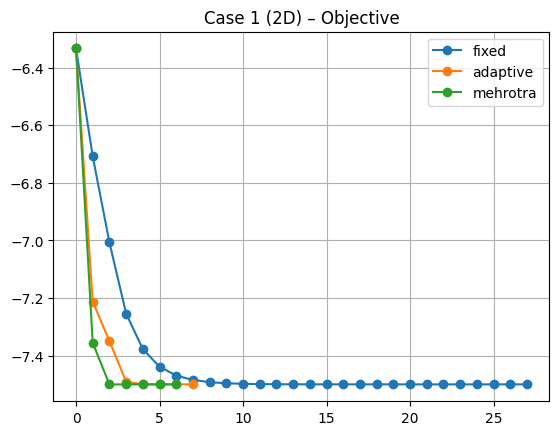

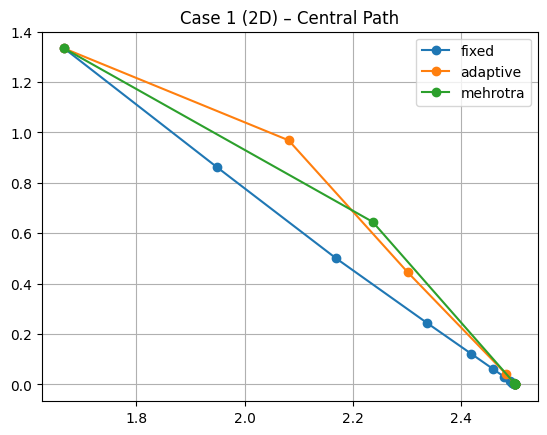

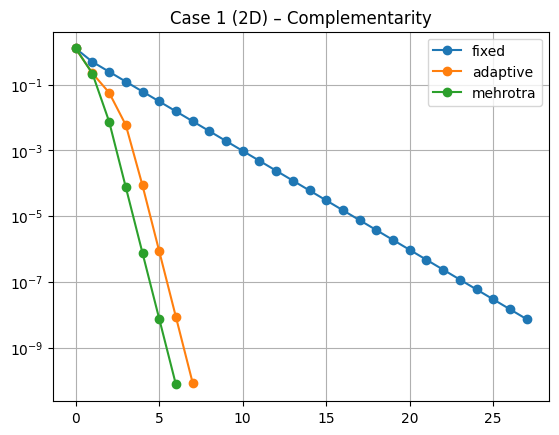

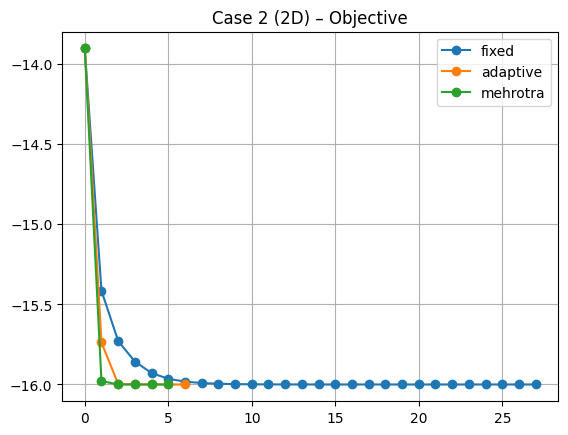

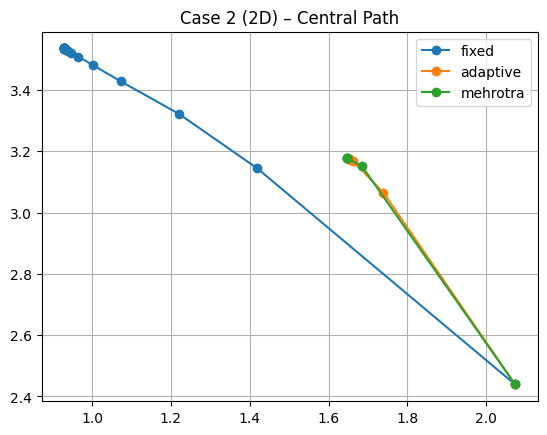

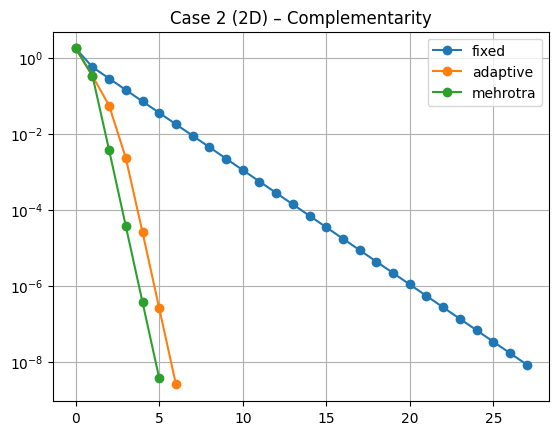

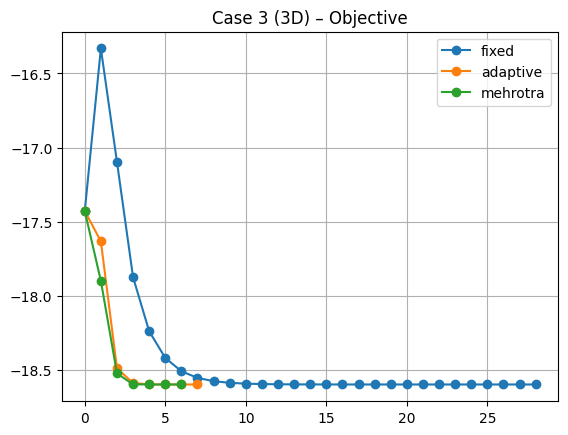

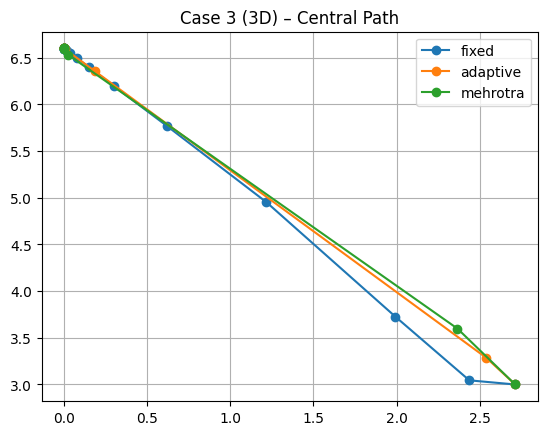

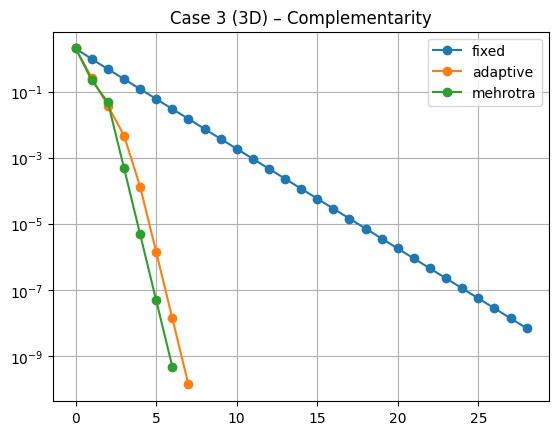

In [9]:
for name, c, A_ub, b_ub in case_studies():
    A_eq, b_eq, c_std = lp_inequalities_to_standard(c, A_ub, b_ub)

    hist_fixed = ipm_central_fixed(A_eq, b_eq, c_std, max_iter=40)
    hist_adapt = ipm_central_adaptive(A_eq, b_eq, c_std, max_iter=40)
    hist_meh = ipm_mehrotra(A_eq, b_eq, c_std, max_iter=40)

    histories = {
        "fixed": hist_fixed,
        "adaptive": hist_adapt,
        "mehrotra": hist_meh,
    }

    plot_case_study(name, histories)
    compare_with_scipy(name, c, A_ub, b_ub, hist_meh)

plt.show()
